Elastic Modulus and Poissons Ratio Fitting & Viewer

In [ ]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt; import numpy as np
from pvc_tensile_experiment.Functions import *

def LinearFit(x, a, b):
    return a*x + b

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)

# create a dataframe to save the data 
df = pd.DataFrame(columns = ["Plasticizer", "Elastic Modulus (Pa)", "Poissons Ratio", "Bulk Modulus"])
i = 0

# plot parameters
markerSize = 0.5
titleSize = 15
axisSize = 11
legendSize = 11

# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # compile all the data  
    _, axStrain, _, transStrain, stress = InstronDataCompile('Elastic Data', plastiRatio)

    # define the elastic region
    elasRegion = np.where(axStrain < 0.3) 

    # curve fit the elastic region. 
    xfit = np.linspace(axStrain[elasRegion][0], axStrain[elasRegion][-1])
    poptE, pcovE = curve_fit(LinearFit, axStrain[elasRegion], stress[elasRegion]*1e6)
    poptP, pcovP = curve_fit(LinearFit, axStrain[elasRegion], transStrain[elasRegion])

    # plot engineering stress vs strain
    plt.figure(0)
    plt.scatter(axStrain[elasRegion], stress[elasRegion]*1e6, s = markerSize, label = f'{plastiRatio}, $R^2$ = {np.round(RSquared(stress[elasRegion]*1e6, LinearFit(axStrain[elasRegion], poptE[0], poptE[1])), 3)}')
    plt.plot(xfit, LinearFit(xfit, poptE[0], poptE[1]), 'black')
    plt.xlabel('Axial Strain', fontsize = axisSize)
    plt.ylabel('Stress (Pa)', fontsize = axisSize)
    plt.title(f'Elastic Modulus', fontsize = titleSize)
    plt.legend(fontsize = legendSize)

    # plot poissons ratio
    plt.figure(1)
    plt.scatter(axStrain[elasRegion], transStrain[elasRegion], s = markerSize, label = f'{plastiRatio}, $R^2$ = {np.round(RSquared(transStrain[elasRegion], LinearFit(axStrain[elasRegion], poptP[0], poptP[1])), 3)}')
    plt.plot(xfit, LinearFit(xfit, poptP[0], poptP[1]), 'black')
    plt.xlabel('Axial Strain', fontsize = axisSize)
    plt.ylabel('Transverse Strain', fontsize = axisSize)
    plt.title(f'Poissons Ratio', fontsize = titleSize)
    plt.legend(fontsize = legendSize)

    df.loc[i] = [plastiRatio, poptE[0], poptP[0], poptE[0]/2/(1 - 2*poptP[0])]
    i = i + 1
plt.show()

# df.to_csv(f"Data/PVC Gel Material Parameters.csv", sep = ',', header = True, index = False)

Elastic Modulus Data Excel Combiner & Exporter

In [ ]:
from pvc_tensile_experiment.Functions import *; import numpy as np


# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # compile all the data  
    _, axStrain, _, transStrain, stress = InstronDataCompile('Elastic Data', plastiRatio)

    # find the elastic region
    elasRegion = np.where(axStrain < 0.3) 

    # save the nominal stress and stretch data 
    df = pd.DataFrame(columns = ["Transverse Strain", "Eng. Axial Strain", "Eng. Stress (Pa)"])
    df["Transverse Strain"] = transStrain[elasRegion]
    df["Eng. Axial Strain"] = axStrain[elasRegion]
    df["Eng. Stress (Pa)"] = stress[elasRegion]    
    
    # df.to_csv(f"Data/{plastiRatio} Uniaxial Tensile Data.csv", sep = ',', header = True, index = False)


Hyperelastic Data and Incompressibilty Assumption Viewer

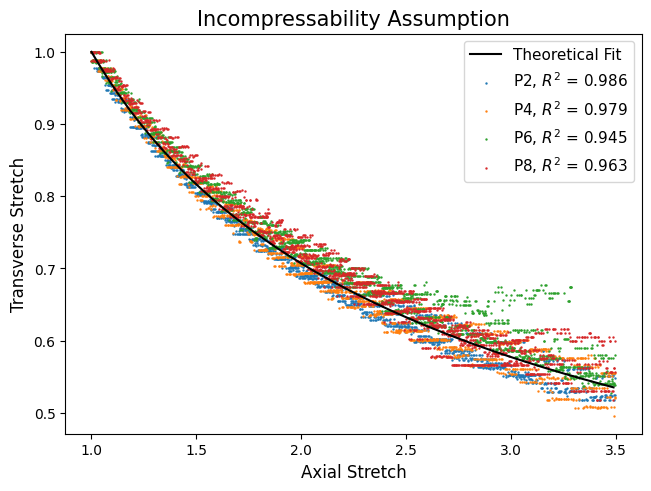

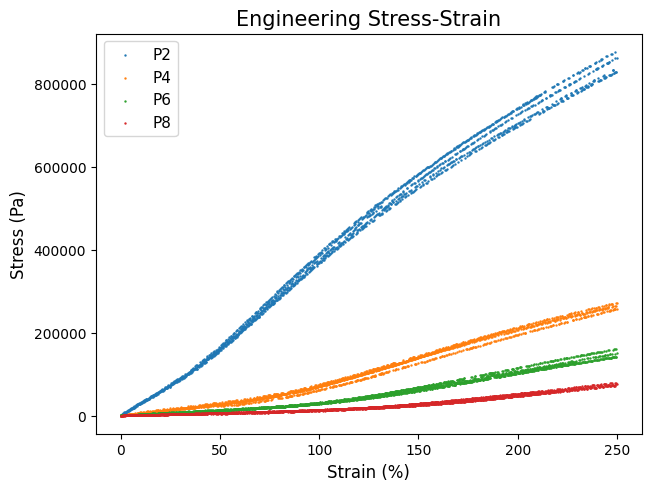

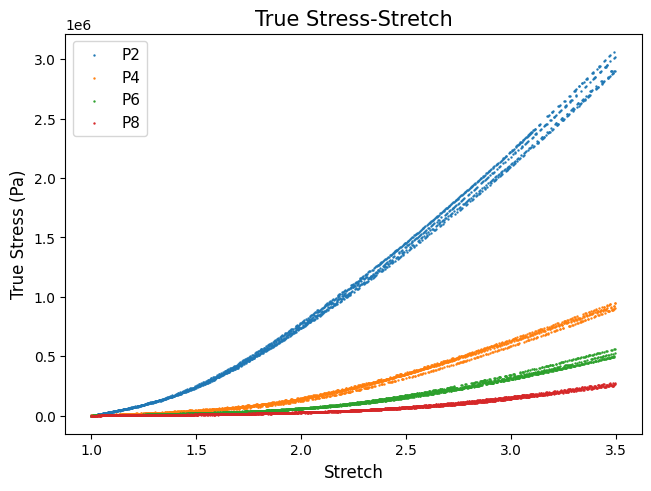

In [31]:
from pvc_tensile_experiment.Functions import InstronDataCompile
import matplotlib.pyplot as plt; import numpy as np

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)

# preallocate the suplots
fig, axs1 = plt.subplots(1,1, layout = "constrained")
fig, axs2 = plt.subplots(1,1, layout = "constrained")
fig, axs3 = plt.subplots(1,1, layout = "constrained")

# plot parameters
markerSize = 0.5
titleSize = 15
axisSize = 12
legendSize = 11

# plot the ideal incompressability condition. this doesn't effect the coefficient of determination
stretch = np.arange(1.0, 3.5, 0.01)
axs1.plot(stretch, np.sqrt(1/stretch), label = 'Theoretical Fit', c = 'k')
axs1.legend(fontsize = legendSize)

# the desired plasticizer ratio 
for plastiRatio in ['P2', 'P4', 'P6', 'P8']:

    # read the processed data files 
    _, axStrain, _, transStrain, stress = InstronDataCompile(f'Hyperelastic Data/', plastiRatio)

    # read only up to 250 % strain
    indices = np.where(axStrain < 2.5) 
    indices = range(0, indices[0][-1], 25)
    axStrain = axStrain[indices]

    # find true strain and stress from engineering strain
    stretch = 1 + axStrain
    transverseStretch = 1 + transStrain[indices]
    stress = stress[indices]*1e6
    stressTrue = stress*stretch

    # print the coeff of determination per dataset
    coeffDet = RSquared(np.sqrt(1/stretch[np.isnan(stretch) == False]), -transverseStretch[np.isnan(stretch) == False] + 2)

    # plot inverse stretch ratio showing isotropic and incompressable
    axs1.scatter(stretch, -transverseStretch + 2, label = f'{plastiRatio}, $R^2$ = {np.round(coeffDet, 3)}', s = markerSize)
    axs1.set_xlabel('Axial Stretch', fontsize = axisSize)
    axs1.set_ylabel('Transverse Stretch', fontsize = axisSize)
    axs1.set_title("Incompressability Assumption", fontsize = titleSize)
    axs1.legend(fontsize = legendSize)

    # plot engineering stress-strain 
    axs2.scatter(axStrain*1e2, stress, s = markerSize, label = f'{plastiRatio}')   
    axs2.set_xlabel('Strain (%)', fontsize = axisSize)
    axs2.set_ylabel('Stress (Pa)', fontsize = axisSize)
    axs2.set_title('Engineering Stress-Strain', fontsize = titleSize)
    axs2.legend(fontsize = legendSize)
    
    # plot true stress-strain
    axs3.scatter(stretch, stressTrue, s = markerSize, label = f'{plastiRatio}')
    axs3.set_xlabel('Stretch', fontsize = axisSize)
    axs3.set_ylabel('True Stress (Pa)', fontsize = axisSize)
    axs3.set_title('True Stress-Stretch', fontsize = titleSize)
    axs3.legend(fontsize = legendSize)
plt.show()

Hyperealastic Fitting

Neo-Hookean
    GA params: [243726.42300696]
    Lm params: [243726.27072555]


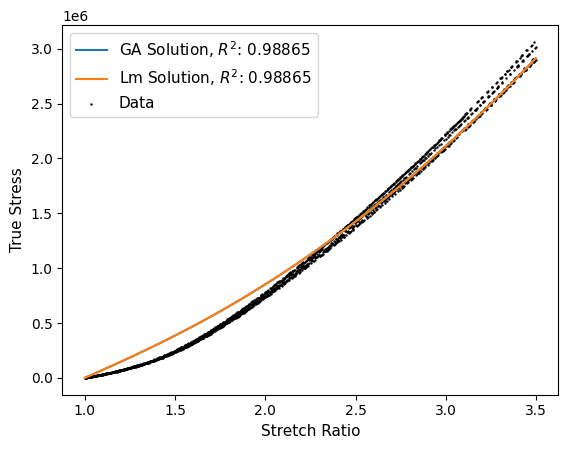

Mooney-Rivlin
    GA params: [155306.25528949 -94148.78273008]
    Lm params: [155315.04068604 -94171.5926941 ]


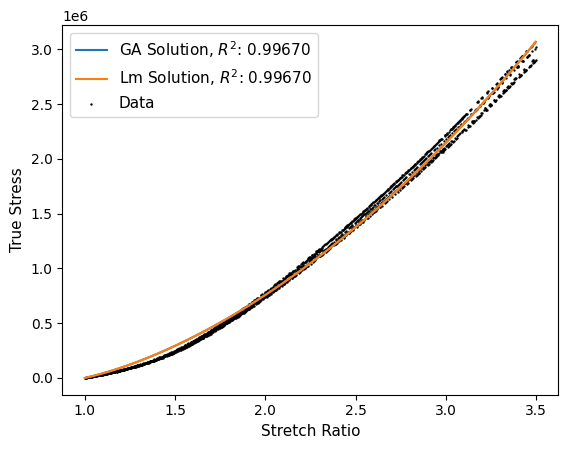

Yeoh
    GA params: [1.15115833e+05 9.79500835e+00 4.78922627e+01]
    Lm params: [85622.47667124  5799.69405858  -271.88829747]


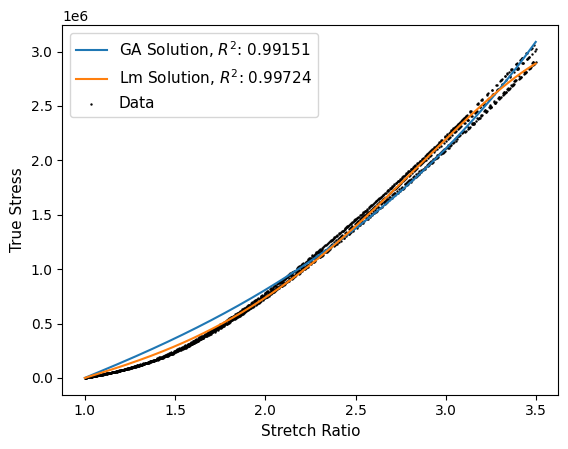

Gent
    GA params: [2.19808211e+05 6.57646633e+01]
    Lm params: [2.19823164e+05 6.57933395e+01]


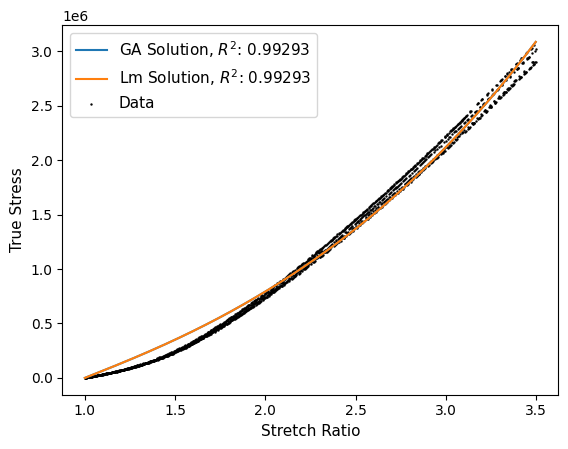

Extended Tube
    GA params: [1.77980237e+05 5.46069670e+04 6.45023045e+00 1.00000000e-07]
    Lm params: [1.78137534e+05 5.44131435e+04 6.45327000e+00 1.00000000e-07]


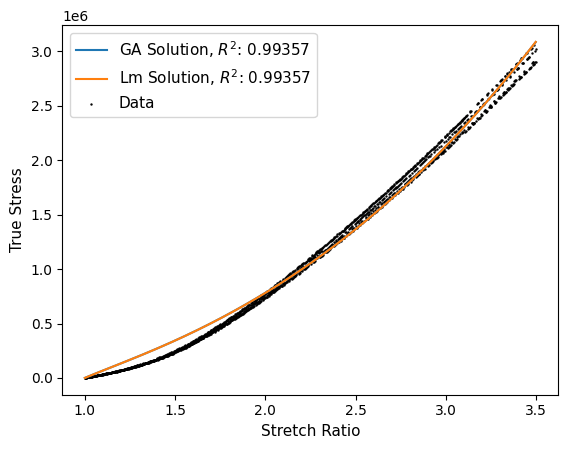

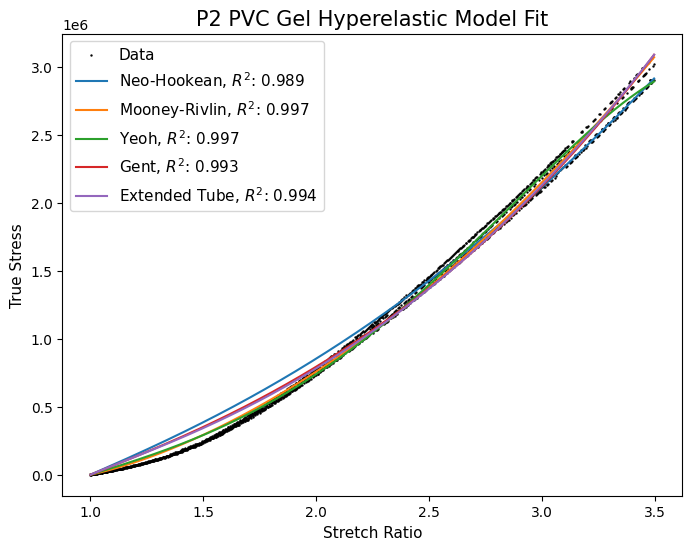

Neo-Hookean
    GA params: [66024.8444115]
    Lm params: [66024.93294007]


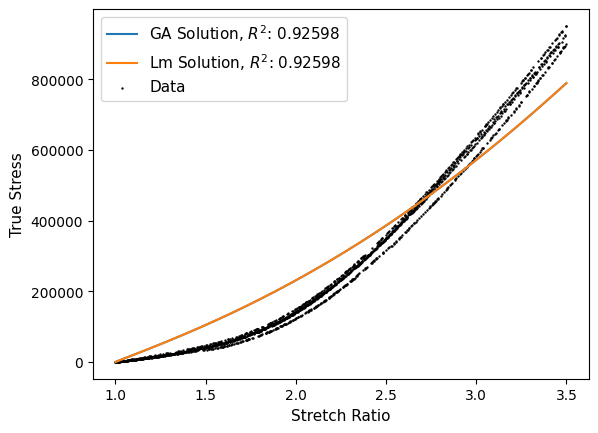

Mooney-Rivlin
    GA params: [ 62579.22036568 -82183.51929522]
    Lm params: [ 62580.01918555 -82182.25507685]


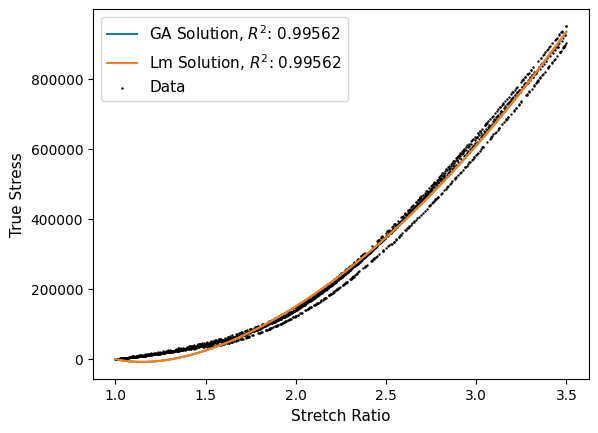

Yeoh
    GA params: [2.49729716e+04 9.95437461e+00 5.96882351e+01]
    Lm params: [9060.60113198 3174.86938693 -115.75175893]


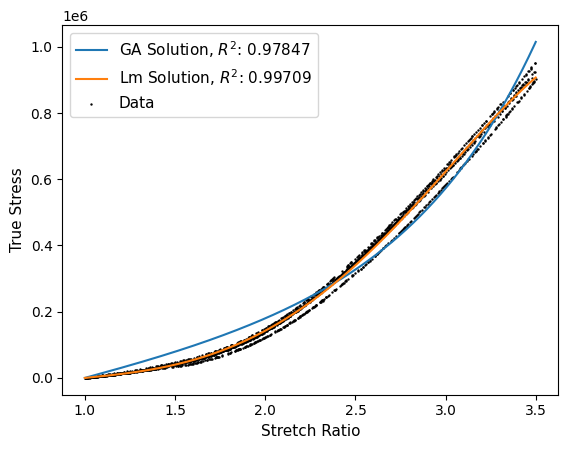

Gent
    GA params: [4.64100258e+04 2.19586085e+01]
    Lm params: [4.64045913e+04 2.19550907e+01]


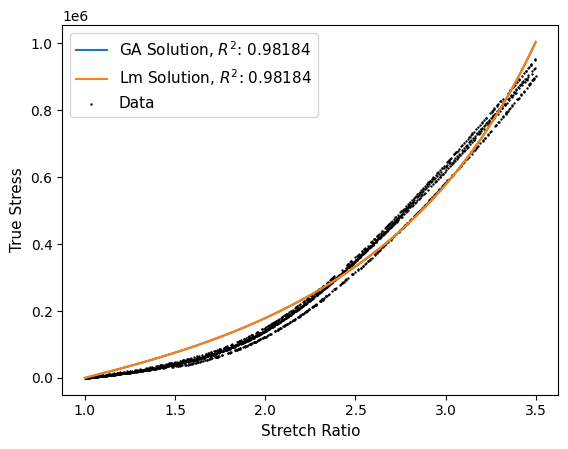

Extended Tube
    GA params: [1.28719035e+01 5.42617135e+04 6.51072881e+00 1.09066681e-02]
    Lm params: [ 1.28717892e+01  5.42617136e+04  6.51072912e+00 -2.72138548e-05]


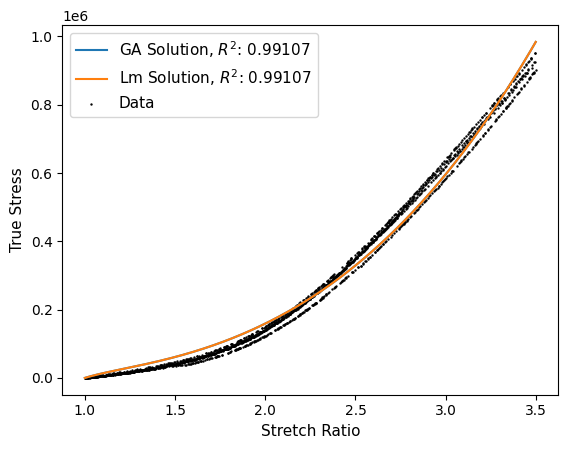

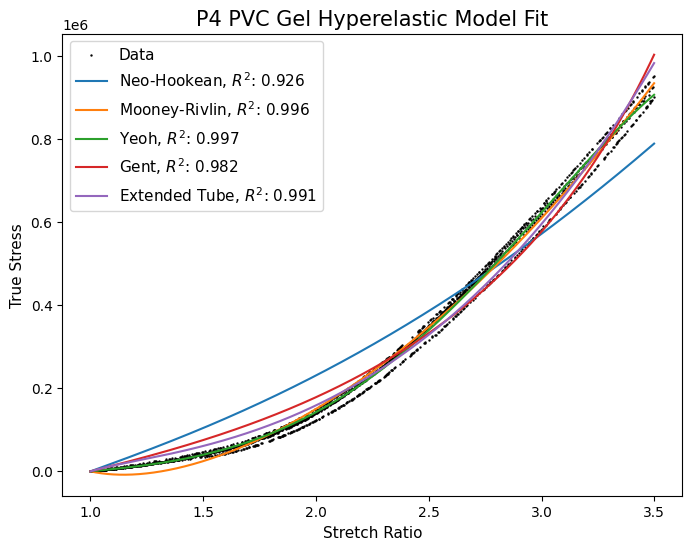

Neo-Hookean
    GA params: [34212.84300591]
    Lm params: [34212.60605189]


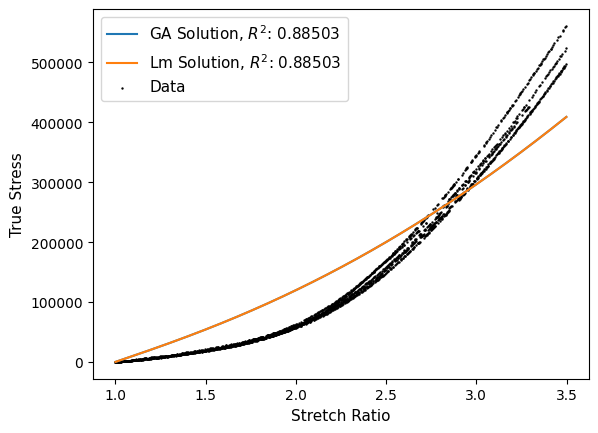

Mooney-Rivlin
    GA params: [ 37252.82340868 -56589.30545023]
    Lm params: [ 37253.91818211 -56593.42901507]


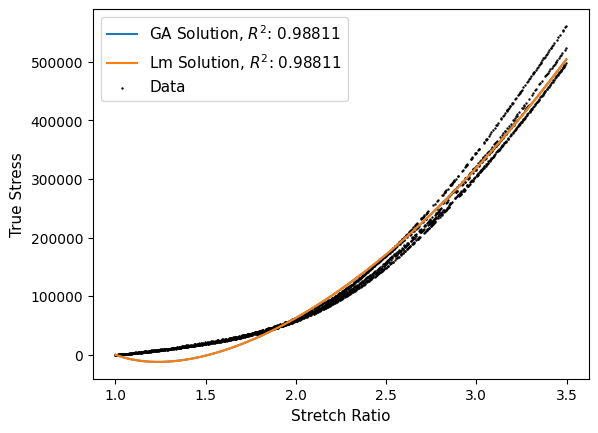

Yeoh
    GA params: [1.10124266e+04 9.99738729e+00 4.45506216e+01]
    Lm params: [3105.57518768 1545.47682694  -40.19706087]


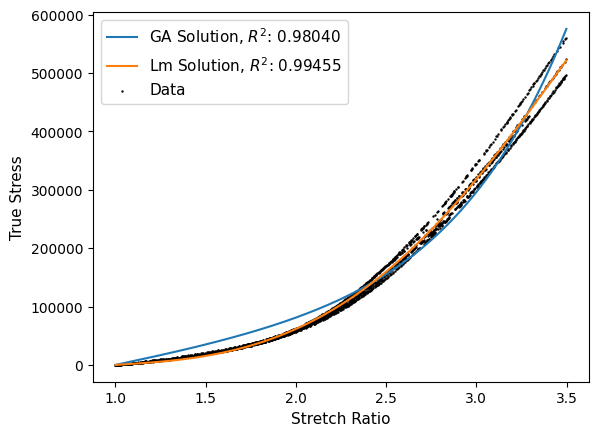

Gent
    GA params: [2.12079564e+04 1.75934248e+01]
    Lm params: [2.12057090e+04 1.75917148e+01]


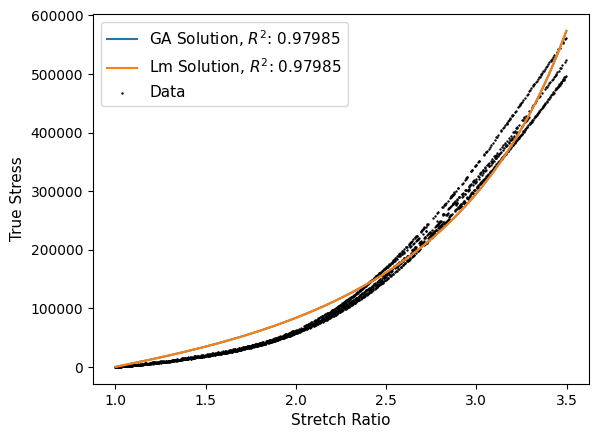

Extended Tube
    GA params: [3.39276938e+00 1.94919229e+04 7.41940861e+00 8.96178885e-03]
    Lm params: [ 3.39117503e+00  1.94919229e+04  7.41940679e+00 -4.42628706e-04]


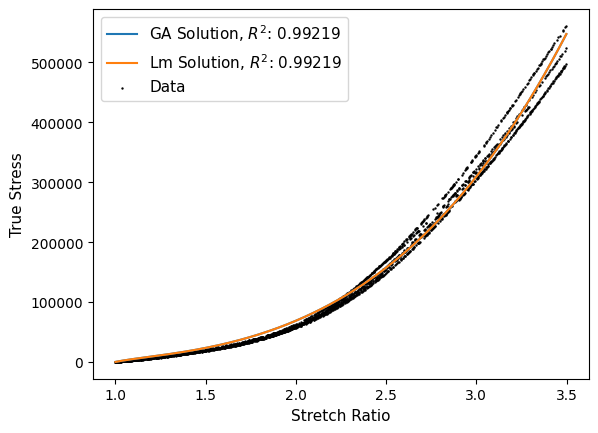

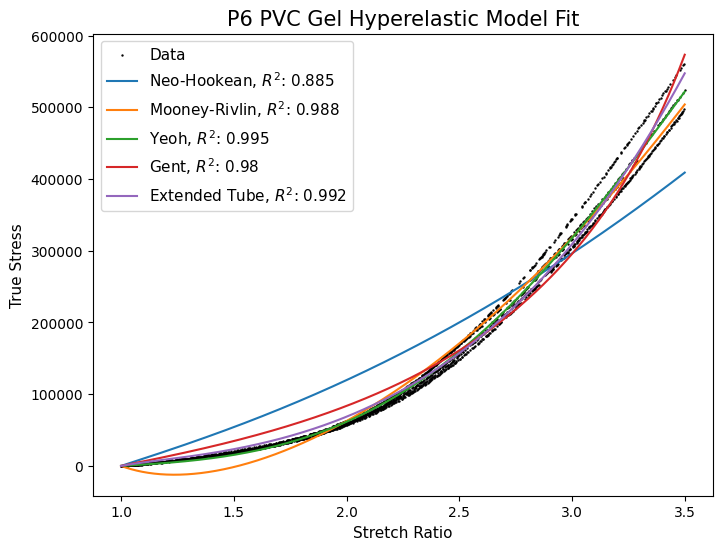

Neo-Hookean
    GA params: [15643.05460307]
    Lm params: [15642.96754056]


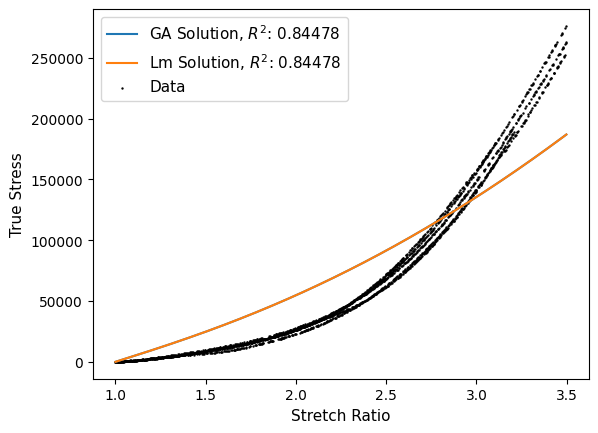

Mooney-Rivlin
    GA params: [ 18948.45716977 -30956.27690021]
    Lm params: [ 18949.26182458 -30959.16392918]


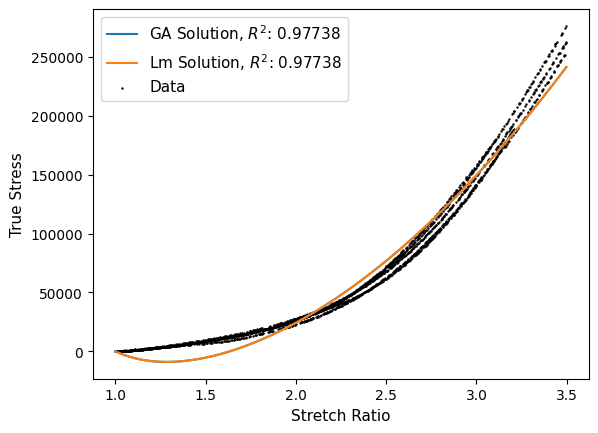

Yeoh
    GA params: [4397.18578014   10.           26.30722179]
    Lm params: [1365.2062953   593.11738367   -5.9915063 ]


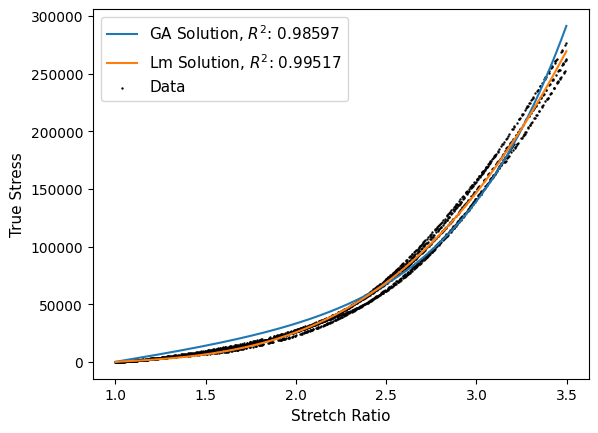

Gent
    GA params: [9007.64521866   15.45778414]
    Lm params: [9008.00610123   15.45839236]


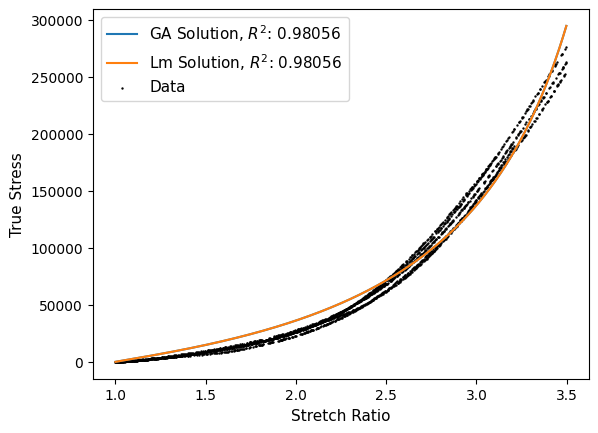

Extended Tube
    GA params: [1.80706475e+00 6.40041493e+03 8.26947328e+00 2.52940730e-02]
    Lm params: [-4.18858738e-01  6.40053855e+03  8.26983454e+00  2.05166012e-01]


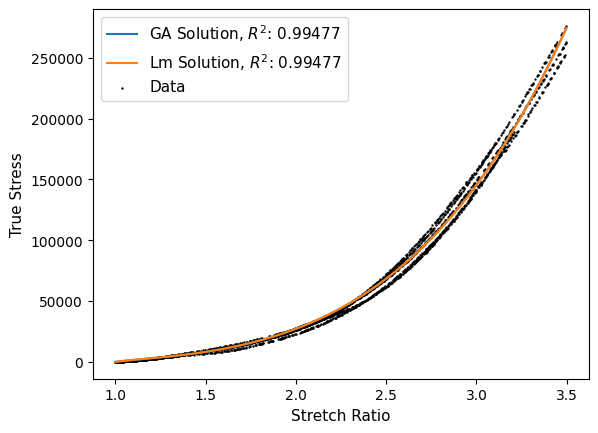

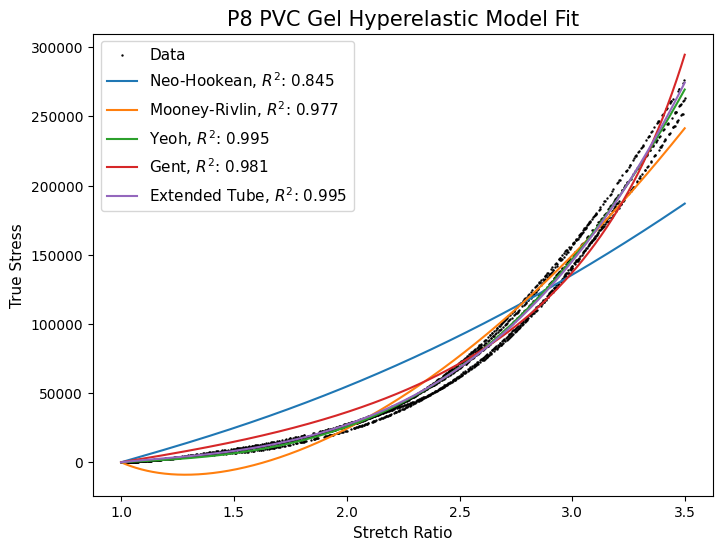

In [42]:
"""True Stress- Strain Hyperelastic Model Fitting"""
import numpy as np; import scipy.optimize as opt
import matplotlib.pyplot as plt
from pvc_tensile_experiment.Functions import *

# define hyperelastic models
def NeoHookean(params, stretch):
    mu = params[0]
    return mu*(stretch**2 - 1/stretch)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch**2 - 1/stretch)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch**2 - 1/stretch)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def InvLangevin(x):
    if np.abs(x) < 0.84136:
        return 1.31446*np.tan(1.58986*x) + 0.91209*x
    elif np.abs(x) >= 0.84136:
        return 1/(np.abs(x)/x*-x)

def EightChain(params, stretch):
    mu, stretchLock = params
    chainStretch = np.sqrt((stretch**2 + 2/stretch)/3)    
    return mu/chainStretch*(stretch**2 - 1/stretch)*InvLangevin(chainStretch/stretchLock)/InvLangevin(1/stretchLock)

def Ogden(params, stretch):
    mu, alpha, mu1, alpha1, mu2, alpha2 = params
    return 2*mu/alpha*(stretch**(alpha) - stretch**(-alpha/2)) + 2*mu1/alpha1*(stretch**(alpha1) - stretch**(-alpha1/2)) + 2*mu2/alpha2*(stretch**(alpha2) - stretch**(-alpha2/2))

def Gent(params, stretch):
    mu, Jm = params
    return mu*(stretch**2 - 1/stretch)*(Jm/(Jm - (stretch**2 + 2/stretch - 3)))

def ExtendedTube(params, stretch):
    Gc, Ge, beta, delta = params
    I1 = stretch**2 + 2/stretch
    return Gc*(stretch**2 - 1/stretch)*((1 + (1 + I1**2 - 4*I1)*delta**2 + (5*I1 - I1**2 - 6)*delta**4)/(1 - (I1 - 3)*delta**2)**2) - 2*Ge/beta*(stretch**(-beta) - stretch**(beta/2))


# define the model fitting function
def FitModel(model, stretch, trueStress, boundaries):
    # define the residual function and the NRMS function
    def Residuals(params):
        return model(params, stretch) - trueStress

    def NRMS(params):
        return np.sqrt(np.mean(Residuals(params)**2))/np.sqrt(np.mean(trueStress**2))

    # run the genetic algorithm 10 times and store the results
    optInitialGuess = np.zeros([0, len(boundaries)])
    for i in range(0, 10):
        initialGuess = opt.differential_evolution(NRMS, bounds = boundaries, popsize = 500).x
        optInitialGuess = np.vstack([optInitialGuess, initialGuess])

    # average the genetic algorithm then pass results to the LM method
    optInitialGuess = np.average(optInitialGuess, axis = 0)
    optParams, _ = opt.least_squares(Residuals, optInitialGuess, method = 'lm', max_nfev = 500).x, None
    print(f'    GA params: {optInitialGuess}')
    print(f'    Lm params: {optParams}')

    # show the solution of both solvers
    plt.plot(stretch, model(initialGuess, stretch), label = f'GA Solution, $R^2$: {RSquared(trueStress, model(initialGuess, stretch)):.5f}')
    plt.plot(stretch, model(optParams, stretch), label = f'Lm Solution, $R^2$: {RSquared(trueStress, model(optParams, stretch)):.5f}')
    plt.scatter(stretch, trueStress, s = markerSize, label = "Data", color = "black")
    plt.xlabel("Stretch Ratio", fontsize = axisSize)
    plt.ylabel("True Stress", fontsize = axisSize)
    plt.legend(fontsize = legendSize)
    plt.show()
    return optParams

# compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)


# define the plasticizer ration we want
plastiRatio = ['P2', 'P4', 'P6', 'P8']

for i in plastiRatio:
    # compile all the data  
    _, axStrain, _, transStrain, stress = InstronDataCompile('Hyperelastic Data', i)
   
    # read only up to 250 % strain
    indices = np.where(axStrain < 2.5) 
    indices = range(0, indices[0][-1], 25)

    # convert to true stress-strain
    stretch = 1 + axStrain[indices]
    trueStress = stress[indices]*stretch*1e6

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 11

    # models and initial guesses
    models = {"Neo-Hookean": (NeoHookean, [(0.1, 5e7)]),
                "Mooney-Rivlin": (MooneyRivlin, ([1e3, 1e6], [-1e6, 1e4])),
                "Yeoh": (Yeoh,  ([1e2, 1e6], [-1e5, 1e1], [1e1, 1e3])),
                "Gent": (Gent, ([1e1 , 1e6], [1, 200])),
                # # "Arruda-Boyce": (EightChain, [1.0, 10]),
                # "Ogden": (Ogden, ([1e3, 1e7], [-5, 5], [1e2, 1e6], [-1, 3], [1e1, 1e6], [1, 5])),
                "Extended Tube": (ExtendedTube, ([1, 10.0e6], [100, 5e6], [0.1, 10], [1e-7, 0.1]))
                }

    # Fit models
    fitResults = {}

    for name, (model, boundaries) in models.items():
        print(name)
        params = FitModel(model, stretch, trueStress, boundaries)
        r2 = RSquared(trueStress, model(params, stretch))
        fitResults[name] = (params, r2)


    # Plot results
    plt.figure(figsize = (8, 6))
    plt.scatter(stretch, trueStress, s = markerSize, label = "Data", color = "black")

    for name, (params, r2) in fitResults.items():
        plt.plot(stretch, models[name][0](params, stretch), label = f'{name}, $R^2$: {np.round(r2, 3)}')

    plt.xlabel("Stretch Ratio", fontsize = axisSize)
    plt.ylabel("True Stress", fontsize = axisSize)
    plt.legend(fontsize = legendSize)
    plt.title(f'{i} PVC Gel Hyperelastic Model Fit', fontsize = titleSize)
    plt.show()

MISC. & Old Functions

In [ ]:
"""Nominal Engineering-Stretch Hyperelastic Model Fitting"""
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from pvc_tensile_experiment.Functions import *


# define the plasticizer ration we want
plastiRatio = 'P2'

# compile all the data  
_, axStrain, _, _, stress = InstronDataCompile('Hyperelastic Data', plastiRatio)

# convert from engineering measurements to true measurements
stretch = 1 + axStrain
stress = stress*1e6

# Define hyperelastic models
def NeoHookean(params, stretch):
    mu = params[0]
    return mu*(stretch - 1/stretch**2)

def MooneyRivlin(params, stretch):
    C10, C01 = params
    return 2*(stretch - 1/stretch**2)*(C10 + C01/stretch)

def Yeoh(params, stretch):
    C10, C20, C30 = params
    I1 = stretch**2 + 2/stretch
    return 2*(stretch - 1/stretch**2)*(C10 + 2*C20*(I1 - 3) + 3*C30*(I1 - 3)**2)

def InvLangevin(x):
    if np.abs(x) < 0.84136:
        return 1.31446*np.tan(1.58986*x) + 0.91209*x
    elif np.abs(x) >= 0.84136:
        return 1/(np.abs(x)/x*-x)

def EightChain(params, stretch):
    mu, stretchLock = params
    chainStretch = np.sqrt((stretch**2 + 2/stretch)/3)    
    return mu/chainStretch*(stretch**2 - 1/stretch)*InvLangevin(chainStretch/stretchLock)/InvLangevin(1/stretchLock)

def Ogden(params, stretch):
    mu, alpha, mu1, alpha1, mu2, alpha2 = params
    return 2*mu/alpha*(stretch**(alpha - 1) - stretch**(-alpha/2 - 1)) + 2*mu1/alpha1*(stretch**(alpha1 - 1) - stretch**(-alpha1/2 - 1)) + 2*mu2/alpha2*(stretch**(alpha2 - 1) - stretch**(-alpha2/2 - 1))

def Gent(params, stretch):
    mu, Jm = params
    return mu*(stretch - 1/stretch**2)*(Jm/(Jm - (stretch**2 + 2/stretch - 3)))

def ExtendedTube(params, stretch):
    Gc, Ge, beta, delta = params
    I1 = stretch**2 + 2/stretch
    return Gc*(stretch - 1/stretch**2)*((1 + (1 + I1**2 - 4*I1)*delta**2 + (5*I1 - I1**2 - 6)*delta**4)/(1 - (I1 - 3)*delta**2)**2) - 2*Ge/beta*(stretch**(-beta) - stretch**(beta/2))


# Define fitting function
def FitModel(model, stretch, stress, paramGuess):
    def residuals(params):
        return model(params, stretch) - stress
    optParams, _ = opt.least_squares(residuals, paramGuess, method = 'lm', max_nfev = 1000).x, None
    return optParams

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)


# Models and initial guesses
models = {
    "Neo-Hookean": (NeoHookean, [1.0e6]),
    "Mooney-Rivlin": (MooneyRivlin, [1.0e6, 0.1e6]),
    "Yeoh": (Yeoh, [1.0e6, -0.1e4, 0.01e2]),
    "Gent": (Gent, [1.0e1, 100e6]),
    # "Arruda-Boyce": (EightChain, [1.0, 10]),
    "Ogden": (Ogden, [10.0e4, 1.0, -7.0e4, 2.0,  5.0e4, 2.0]),
    "ExtendedTube": (ExtendedTube, [1.0e6, 1.0e6, 0.7, 0.1])
}

# Fit models
fitResults = {}
for name, (model, guess) in models.items():
    params = FitModel(model, stretch, stress, guess)
    predictedStress = model(params, stretch)
    r2 = RSquared(stress, predictedStress)
    fitResults[name] = (params, r2)

# Print results
for name, (params, r2) in fitResults.items():
    print(f"{name} Model: Parameters = {params}, R^2 = {r2:.4f}")

# Plot results
plt.figure(figsize = (8, 6))
plt.scatter(stretch, stress, s = 2, label = "Data", color = "black")

for name, (params, _) in fitResults.items():
    plt.plot(stretch, models[name][0](params, stretch), label = name, linewidth = 2, linestyle = 'dotted')

plt.xlabel("Stretch Ratio")
plt.ylabel("Nominal Stress (MPa)")
plt.legend()
plt.title("Hyperelastic Model Fits")
plt.show()
